# Logarithmic Frequency Resolution
The human ear analyses frequencies in a logarithmic way.

Therefore, the notes of western music are based on a logarithmic frequency resolution:

An octave doubles the frequency. An octave consists of 12 halftones. A fifth (lat.: quinte) describes a frequency relation of: $\frac{f_2}{f_1}=\frac{3}{2}$.

If you want to find out, how many half tones coresponds to a fith the following steps need to be done:

$\left(2^{1/12}\right)^n = \frac{3}{2}$

$\rightarrow2^{n/12} = \frac{3}{2}$

$\rightarrow\frac{n}{12}=\log_2\frac{3}{2}$

$\rightarrow n = 12\log_2\frac{3}{2}=7.02\approx7$

The following code shows the logarithmic mapping from frequencies in Hertz to half tones:

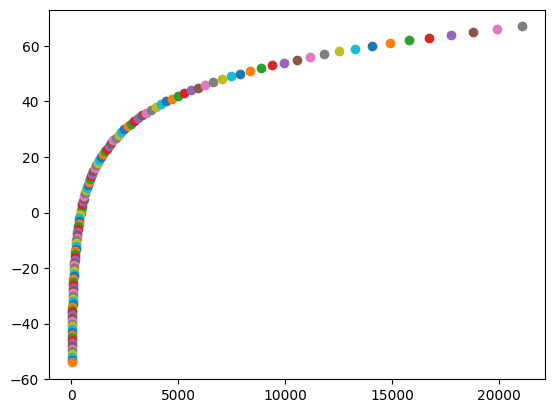

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Halftonestep = 2**(1/12)

# assuming the standard note a as a reference
f = 440
Tone = 0
plt.scatter(f, Tone)
while f < 20000:
    Tone += 1
    f *= Halftonestep
    plt.scatter(f, Tone)
f = 440
Tone = 0
while f >20:
    Tone -= 1
    f /= Halftonestep
    plt.scatter(f, Tone)
plt.show()

## Bark-scale

The Bark-scale represents the logarithmic frequency analysis of the human ear. The real Bark-scale is a table based on psychoacoustic experiments. In the context of this course, we will use the following approximations of the experiment-based table to transform from the frequency $f$ in kHz to the logarithmic frequency $b$ in Bark:

$\frac{f}{\text{kHz}} = 1.96\cdot\frac{b+0.53}{26.28-b}$

$b = 26.81\cdot\frac{\frac{f}{\text{kHz}}}{1.96 + \frac{f}{\text{kHz}}}-0.53$

The Bark scale is usually restricted to $0 \leq b \leq 24$ in Bark. This corresponds to a frequency range of $40 \leq f \leq 21087$ in Hertz.

The frequencies noticable by humans are usually defined by:  $16 \leq f \leq 16000$ in Hertz.

Another popular psychoacoustic measure is mel. 1 Bark corresponds to 100 mel.

Frequency: f =  [17078.82408339]  Hz
Bark: b =  [23.5199766]
mel: m =  [2351.99765989]
frequency range of human beings
0 Bark corresponds to  39.52815829528158
24 Bark corresponds to  21087.19298245613


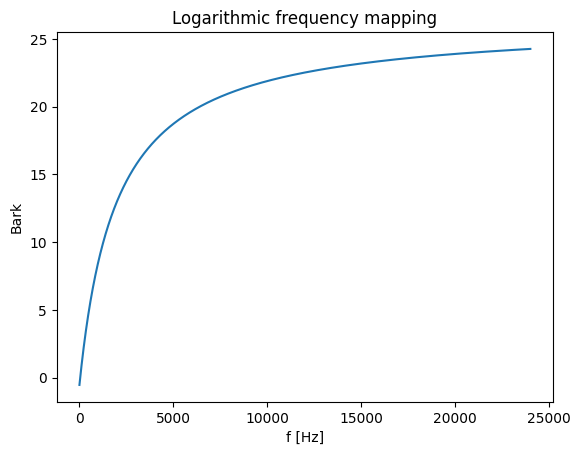

In [2]:
def Bark2KiloHertz(b):
    return 1.96 * (b + 0.53) / (26.28 - b)

def KiloHertz2Bark(f):
    return 26.81 * f / (1.96 + f) - 0.53

# example for conversion from Hertz to Bark or mel:
Fs = 48000
FrequencyInHertz = np.random.rand(1) * Fs / 2
Bark = KiloHertz2Bark(FrequencyInHertz / 1000)
Mel = Bark * 100
print('Frequency: f = ', FrequencyInHertz, ' Hz')
print('Bark: b = ', Bark)
print('mel: m = ', Mel)
assert np.abs(FrequencyInHertz - Bark2KiloHertz(Bark) * 1000) < 1e-10, 'error in Bark to Hertz conversion'

print('frequency range of human beings')
print('0 Bark corresponds to ', Bark2KiloHertz(0)*1000)
print('24 Bark corresponds to ', Bark2KiloHertz(24)*1000)

# plot the logarithmic frequency mapping
f = np.arange(int(Fs/2))
b = KiloHertz2Bark(f / 1000)

plt.plot(f, b)
plt.xlabel('f [Hz]')
plt.ylabel('Bark')
plt.title('Logarithmic frequency mapping')
plt.show()

## Mel Filter Bank
So far, we have learned, how to map linear frequencies in Hertz to logarithmic frequencies in Bark or mel. Now we will see, how to evaluate a spectrum with a logarithmic frequency resolution:

First, a sample voice signal $y(n)$ is loaded and transformed by the DFT:

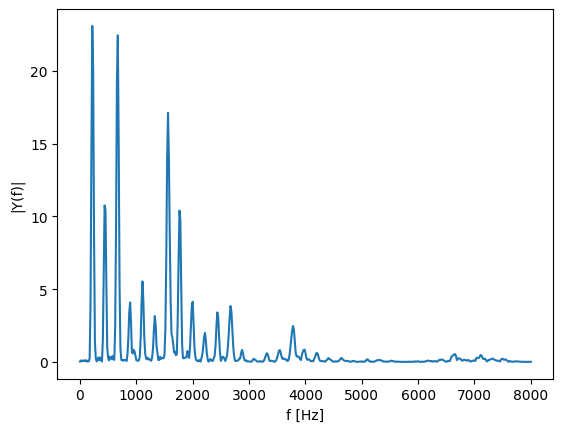

In [3]:
import sys
sys.path.insert(0, '../Python')
import WaveInterface

y, Fs, bits = WaveInterface.ReadWave('../Audio/SevenEnglishFemale.wav')

HopsizeInMilliseconds = 10
hs = int(HopsizeInMilliseconds * Fs / 1000)
ws = 4*hs
w = np.hamming(ws)
FFTLen = int(2**np.ceil(np.log2(ws)))

col = 45
idx1 = col * hs
idx2 = idx1 + ws
y_block = y[idx1:idx2] * w
Y = np.abs(np.fft.rfft(y_block, n = FFTLen))

Delta_T = 1/Fs
Delta_f = 1/(Delta_T * FFTLen)
f = np.arange(Y.shape[0])*Delta_f
plt.plot(f, Y)
plt.ylabel('|Y(f)|')
plt.xlabel('f [Hz]')
plt.show()

The transform from Hertz into mel is usually done by triangular filters with center frequencies linear spaced in Bark or mel.  This transform can be implemented as a matrix multiplication with $T_\text{Hertz2Bark}$. In this matrix, every row corresponds to a single triangular filter.

The matrix multiplication leads to the following mathematical effect: The input vector $Y(k)$ is a magnitude spectrum with frequency indices $k$. These $k$ corresponds to the frequencies $f = \frac{k}{KT}$ with the transform length $K$ and the sampling duration $T$. If a row of the transform matrix $T_\text{Hertz2Bark}$ is a triangular signal, the corresponding frequency indices $k$ are multiplied with values unequal zero. By this, each triangular filter is forming a band pass.

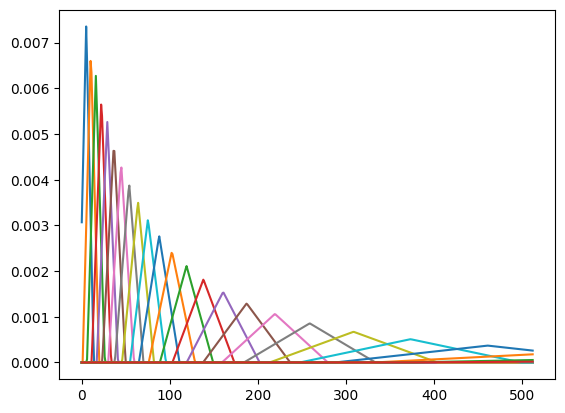

In [4]:
def MelFilterBank(NumberOfCenterFrequenciesPerBark, NumberOfInputFrequencyBins):
    FFTLen = 2 * NumberOfInputFrequencyBins - 2
    Deltaf = Fs / FFTLen
    f = np.arange(NumberOfInputFrequencyBins) * Deltaf
    CutoffFrequenciesInBark = np.arange(24*NumberOfCenterFrequenciesPerBark+1) / NumberOfCenterFrequenciesPerBark
    CutoffFrequenciesInHertz = Bark2KiloHertz(CutoffFrequenciesInBark) * 1000
    CenterFrequenciesInHertz = np.diff(CutoffFrequenciesInHertz) / 2
    CenterFrequenciesInHertz += CutoffFrequenciesInHertz[0:CutoffFrequenciesInHertz.shape[0]-1]
    T_Hertz2Bark = np.zeros((CenterFrequenciesInHertz.shape[0], NumberOfInputFrequencyBins))
    for b in range(T_Hertz2Bark.shape[0]):
        m1 = (1 - 1/np.sqrt(2)) / (CenterFrequenciesInHertz[b] - CutoffFrequenciesInHertz[b]) # first derivative of first line
        m2 = (1 - 1/np.sqrt(2)) / (CenterFrequenciesInHertz[b] - CutoffFrequenciesInHertz[b+1]) # first derivative of second line
        assert m1 > 0, 'm1 must be greater 0'
        assert m2 < 0, 'm2 must be smaller 0'
        b1 = 1 - m1 * CenterFrequenciesInHertz[b] # offset of first line
        b2 = 1 - m2 * CenterFrequenciesInHertz[b] # offset of second line
        assert b1 < 1/np.sqrt(2), 'b1 must be smaller than 1/sqrt(2)'
        assert b2 > 0, 'b2 must be greater 0'
        v1 = m1 * f + b1
        v2 = m2 * f + b2
        v3 = np.minimum(v1, v2)
        v4 = np.maximum(v3, 0.0)
        f1 = -b1 / m1 # zero crossing of the first line
        f2 = -b2 / m2 # zero crossing of the second line
        T_Hertz2Bark[b, :] = v4 / (0.5*(f2 - f1))
    return T_Hertz2Bark, CenterFrequenciesInHertz

T_Hertz2Bark, CenterFrequenciesInHertz = MelFilterBank(NumberOfCenterFrequenciesPerBark = 1, NumberOfInputFrequencyBins = Y.shape[0])

plt.plot(np.transpose(T_Hertz2Bark))
plt.show()

After matrix multiplication, the spectrum with $K$ elements is reduced to a number of band pass filter outputs, typically $1$ per Bark. This corresponds to a smoothing of the spectrum. The more band passes per Bark are used, the more details of the spectrum are retained. The less band passes per Bark are used, the more smoothing is applied to the spectrum.

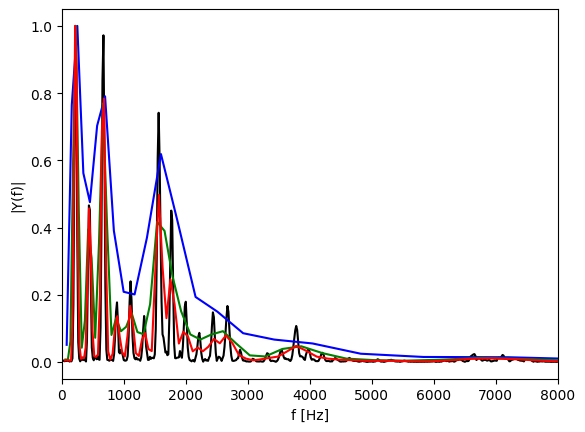

In [5]:
plt.plot(f, Y / np.amax(Y), 'k')

T_Hertz2Bark, CenterFrequenciesInHertz = MelFilterBank(NumberOfCenterFrequenciesPerBark = 1, NumberOfInputFrequencyBins = Y.shape[0])
Y_mel = np.matmul(T_Hertz2Bark, Y)
plt.plot(CenterFrequenciesInHertz, Y_mel / np.amax(Y_mel), 'b')

T_Hertz2Bark, CenterFrequenciesInHertz = MelFilterBank(NumberOfCenterFrequenciesPerBark = 2, NumberOfInputFrequencyBins = Y.shape[0])
Y_mel = np.matmul(T_Hertz2Bark, Y)
plt.plot(CenterFrequenciesInHertz, Y_mel / np.amax(Y_mel), 'g')

T_Hertz2Bark, CenterFrequenciesInHertz = MelFilterBank(NumberOfCenterFrequenciesPerBark = 4, NumberOfInputFrequencyBins = Y.shape[0])
Y_mel = np.matmul(T_Hertz2Bark, Y)
plt.plot(CenterFrequenciesInHertz, Y_mel / np.amax(Y_mel), 'r')

plt.ylabel('|Y(f)|')
plt.xlabel('f [Hz]')
plt.xlim([0, 8000])
plt.show()

## Frequency-resolution of the human ear

The frequency-resolution of the human ear is roughly $\frac{1}{27}$ Bark.

## Programming exercise:

Another typically used approximation of the Bark-scale is the following equation:

$b = 13\cdot\arctan\left(0.00076\cdot f\right)+3.5\cdot\arctan\left(\left(\frac{f}{7500}\right)^2\right)$

Unfortunately, this equation cannot be inverted by a simply equation. But with a scripting language like python, it should be possible to write an inverse procedure:

Write a numerical approximation of the inverse procedure BarkToHertz.

Hint: a good algorithm for the inverse function is the bisection method.
The bisection method finds the root of a function.
Therefore, you must redefine the given problem as a root finding problem.
This is shown in the procedure MySqrt(), which evaluates the square root of $x$. The redefinition of the square root as a root finding algorithm is shown in the following:

$\sqrt{x}=c \rightarrow x = c^2\rightarrow x-c^2=0$

MySqrt(9) =  2.99981689453125


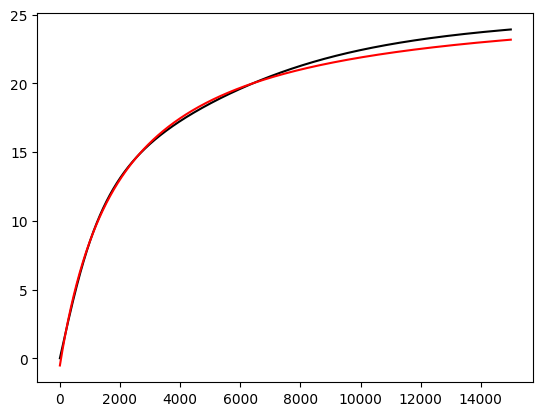

test_BarkToHertzScalar (__main__.TestProgrammingExercise.test_BarkToHertzScalar) ... ok
test_BarkToHertzVector (__main__.TestProgrammingExercise.test_BarkToHertzVector) ... 

time consumption =  1.8208949565887451


ok

----------------------------------------------------------------------
Ran 2 tests in 2.096s

OK


In [17]:
import time

Precision = 1e-3

### introduction to the bisection method
def MySqrt(x):
    a = 0
    b = x
    while (b - a) > Precision:
        c = 0.5 * (a + b)
        if x - c*c < 0:
            b = c
        else:
            a = c
    return c

print('MySqrt(9) = ', MySqrt(9))

### programming exercise

def HertzToBark(f):
    return 13*np.arctan(0.00076*f) + 3.5*np.arctan((f/7500)**2)

def BarkToHertz(bark):
    ### solution
    assert np.amin(bark) >= 0, 'b should be greater or equal zero'
    assert np.amax(bark) <= 24, 'b should be smaller or equal to 24'
    f = np.ones(bark.shape)
    '''
    a = f * 0.0
    b = f * 24000
    while np.amax(b - a) > Precision:
        c = 0.5 * (a + b)
        ChooseUpperInterval = HertzToBark(c) < bark
        a = (1.0 - ChooseUpperInterval) * a + (ChooseUpperInterval + 0.0) * c
        b = (1.0 - ChooseUpperInterval) * c + (ChooseUpperInterval + 0.0) * b
    '''
    for n in range(bark.shape[0]):
        a = 0.0
        b = 24000.0
        while (b - a) > Precision:
            c = 0.5 * (a + b)
            if HertzToBark(c) < bark[n]:
                a = c
            else:
                b = c
        f[n] = c
    return f

f = np.arange(1, 15000)
b = HertzToBark(f)
plt.plot(f, b, 'k')
plt.plot(f, KiloHertz2Bark(f / 1000), 'r')
plt.show()
t0 = time.time()
f_approximation = BarkToHertz(b)
t1 = time.time()
print('time consumption = ', t1-t0)

import unittest

class TestProgrammingExercise(unittest.TestCase):

    def test_BarkToHertzScalar(self):
        f = np.random.rand(1) * 15000
        b = HertzToBark(f)
        f_approximation = BarkToHertz(b)
        self.assertGreater(Precision, np.abs(f - f_approximation))

    def test_BarkToHertzVector(self):
        f = np.arange(1, 15000)
        b = HertzToBark(f)
        f_approximation = BarkToHertz(b)
        self.assertGreater(Precision, np.amax(np.abs(f - f_approximation)))
    
unittest.main(argv=[''], verbosity=2, exit=False)

## Exam preparation

1) Evaluate the frequency $f_1$ corresponding to nine halftones above $f_0=440$ Hz in Hertz, Bark and mel.

2) A fifth is the relation between two frequencies of $\frac{f_1}{f_0}=\frac{3}{2}$. How many halftones corresponds to the fifth?

3) A triangular mel filter has a center frequency at $f_m = 12$ Bark. Its cutoff frequencies are at $f_{c,1}=11.75$ Bark and $f_{c,2}=12.25$ Bark. Evaluate the parameter $m$ and $n$ of the linear rising slope $g_1$ of this filter: $g_1=m\cdot f+n$. For which frequency $f_{0,1}$ is the linear rising slope equal to zero ($g_1=0$)?

4) Evaluate the frequency resolution in Hertz of the human ear for $b=0$ Bark and $b=20$ Bark.